# Bilateral Bargaining: Evaluation of the Experiments

In [1]:
import os
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import pandas as pd

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'bnelearn'))

from bnelearn.util.metrics import ALIASES_LATEX
from scripts.utils import *

In [2]:
### EXP-1 BB 1/2-DA & VCG -----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-1_experiment-v3'

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-1_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the two most common mechanisms in the bilateral bargaining setup. For the average double auction, we only compare the learned strategies to the payoff dominant equilibrium strategies.",
    symmetric = False,
    label = 'tab:exp-1_table'
)

In [3]:
def get_value_and_std_from_df_entry(df_entry: str) -> float:
    list_of_numbers = re.findall('\d+', df_entry)
    return float(list_of_numbers[0] + '.' + list_of_numbers[1]), float(list_of_numbers[2] + '.' + list_of_numbers[3])

In [4]:
### EXP-2 risk experiments ----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-2_experiment-v2'
path += '/double_auction/single_item/k_price/0.5/uniform/symmetric'
exps = dict()
for risk_str in sorted(next(os.walk(path))[1]):
    exps[float(risk_str[5:])] = get_sub_path(path + '/' + risk_str, 2) + '/aggregate_log.csv'

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-2_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    symmetric = False,
    caption = 'Mean and standard deviation of experiments over ten runs' \
        + ' each for differnt risk attitutes of the buyer and seller.',
    label = 'tab:exp-2_table'
)

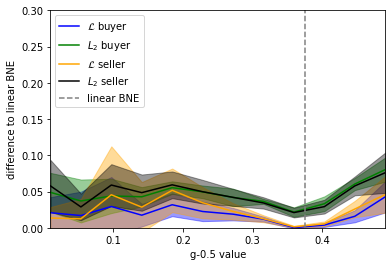

In [10]:
path = '/home/pieroth/bnelearn/experiments/debug/exp-3_experiment_AdamW/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ["eval_vs_bne/epsilon_relative", "eval_vs_bne/L_2"]
metrics_names_latex = ["$\mathcal{L}^\text{BNE{1}}$", "$L_2^\text{BNE{1}}$"]
plot_metric_names_latex = ["$\mathcal{L}$", "$L_2$"]
bidders = ['buyer', 'seller']
exp_names = sorted(os.listdir(path))
metrics = np.zeros((2, 2, len(metrics_names), len(exp_names)))

g_05s = np.zeros(len(exp_names))
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05s[i] = float(json.load(json_file)['setting']['pretrain_transform'])
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    # buyer
    for bidder_id in range(len(bidders)):
        for metric_id in range(len(metrics_names)):
            mean, std = get_value_and_std_from_df_entry(df[metrics_names_latex[metric_id]][bidder_id])
            metrics[bidder_id, 0, metric_id, i] = mean
            metrics[bidder_id, 1, metric_id, i] = std


metrics[metrics != metrics] = np.inf
colors = [['blue', 'green'],
          ['orange', 'black']]

plt.figure()
for bidder_id, bidder in enumerate(bidders):
    for metric_name_id, metric_name in enumerate(plot_metric_names_latex):
        plt.plot(g_05s, metrics[bidder_id, 0, metric_name_id], label=metric_name + ' ' + bidder, color=colors[bidder_id][metric_name_id])
        plt.fill_between(
            g_05s,
            metrics[bidder_id, 0, metric_name_id] - metrics[bidder_id, 1, metric_name_id],
            metrics[bidder_id, 0, metric_name_id] + metrics[bidder_id, 1, metric_name_id],
            alpha=0.4,
            color=colors[bidder_id][metric_name_id])
plt.plot([3./8., 3./8.], [0, 1], '--', color='grey', label=r'linear BNE')
plt.xlabel('g-0.5 value'); plt.ylabel('difference to linear BNE')
plt.xlim([g_05s[0], g_05s[-1]]); plt.ylim([0, .3])
plt.legend(loc='upper left')
plt.savefig(os.curdir + '/exp-3_figure.pdf')
plt.show()

In [6]:
## EXP-3 custom pretraining experiments - Each pretrained BNE individually --------------------------------------
path = '/home/pieroth/bnelearn/experiments/debug/exp-3_experiment_AdamW/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss']
bne_ids = [1, 4]
metric_names_latex = ['pretrain_transform', 'bidder']
for bne_id in bne_ids:
    metric_names_latex.extend(["$\mathcal{L}^\text{BNE{%s}}$" % str(bne_id), "$L_2^\text{BNE{%s}}$" % bne_id])

exp_names = sorted(os.listdir(path))
experiments = {}
df_list = []
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05 = float(json.load(json_file)['setting']['pretrain_transform'])
        g_05 = "{:.2f}".format(g_05)
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    df.insert(0, 'pretrain_transform', [g_05, None])
    df_list.append(df)
combined_df = pd.concat(df_list)
sliced_df = combined_df[metric_names_latex]

df_to_tex(sliced_df, name='exp-3_table_pretrain_transforms_AdamW.tex',
        label='tab:exp-3_table_pretrain_transform',
        caption='Mean and standard deviation of experiments over ten runs' \
        + ' each for a different pretrained non-optimal Equilibrium.')

In [9]:
## EXP-3 custom pretraining experiments - Aggregated over all pretrained BNEs -------------------------------------
path_experiments = '/home/pieroth/bnelearn/experiments/debug/exp-3_experiment_AdamW/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
columns_to_drop = ['wall_time', 'run']
metric_names = ['eval_vs_bne/L_2_bne1', 'eval/estimated_relative_ex_ante_util_loss', 'eval_vs_bne/epsilon_relative_bne1']
latex_col_names = ["$L_2$", "$\hat{\mathcal{L}}$", "$\mathcal{L}$"]
aggregate_cols = ['tag', 'subrun']

row_values_to_filter = {
    'tag': metric_names,
    'epoch': [2000]}

# get all data (this may take some time)
df_dict = get_data_frames_from_multiple_experiments(path_experiments)
filtered_df_dict = {
    key: filter_full_results_df(value, row_values_to_filter, columns_to_drop) for key, value in df_dict.items()
}
concatenated_df = concatenate_dfs_from_dict(filtered_df_dict)
df = concatenated_df.groupby(
        aggregate_cols, as_index=False
    ).agg({'value': ['mean', 'std']})
df.columns = ['metric', 'bidder', 'mean', 'std']
df_mean_std = combine_mean_stddv_into_single_column(df, precision=3)
unstacked_df = df_unstack_values_by_tag_and_index(df_mean_std)
unstacked_df = unstacked_df[metric_names]  # reorder the columns to the given order
unstacked_df.rename({metric_name: latex_name for metric_name, latex_name in zip(metric_names, latex_col_names)}, inplace=True, axis=1)
# store as table
df_to_tex(unstacked_df, name='exp-3_table_all_runs_aggregated_epoch_2000.tex', print_index=True,
        print_index_names=True,
        label='tab:exp-3_table_pretrain_transform_aggregated',
        caption='Mean and standard deviation of experiments over twelve different' \
        + ' pretrained non-optimal Equilibria each run with ten different seeds.')
